# Lab Assignment 3

## Austin Booth

Link: 

### Exercise 1

Text(0.5, 1.0, 'Test plot of set point function sp2')

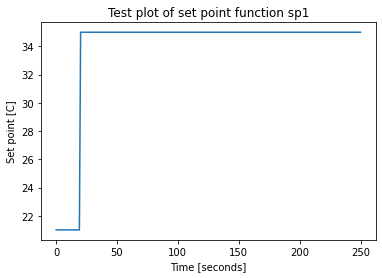

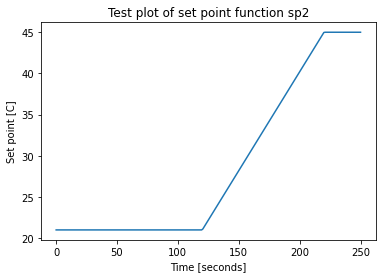

In [23]:
# create function to define set points for H1 and H2 and plot results to check

# import libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# define function to set SP1
def sp1(t):
    if t <= 20:
        return T_amb
    else:
        return 35

# define function to set SP2
def sp2(t):
    if t <= 120:
        return T_amb
    elif t <= 220:
        # set point should be linearly spaced between T_amb and 45
        return T_amb + (45-T_amb)/(220-120)*(t-120)
    else:
        return 45
    
# plot functions

# set T_amb as 21 C for this example
T_amb = 21

# create time vector and y1, y2 vectors
t = np.linspace(0, 250, 250)
y1 = np.array([sp1(tau) for tau in t]) 
y2 = np.array([sp2(tau) for tau in t]) 

# plot SP1
fig, ax = plt.subplots(1, 1)
ax.plot(t, y1)
ax.set_xlabel('Time [seconds]')
ax.set_ylabel('Set point [C]')
ax.set_title('Test plot of set point function sp1')

# plot SP2
fig, ax = plt.subplots(1, 1)
ax.plot(t, y2)
ax.set_xlabel('Time [seconds]')
ax.set_ylabel('Set point [C]')
ax.set_title('Test plot of set point function sp2')

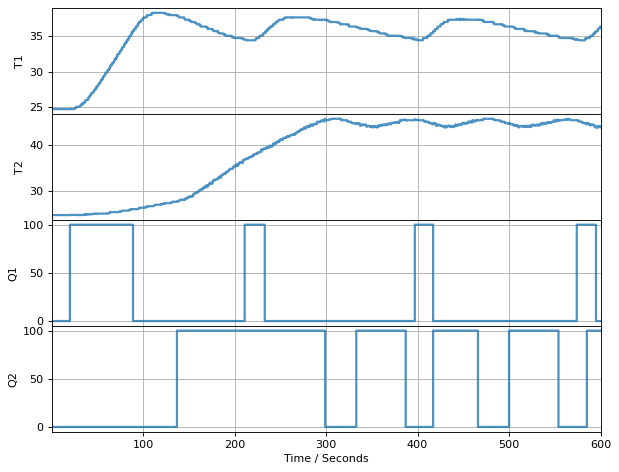

TCLab disconnected successfully.


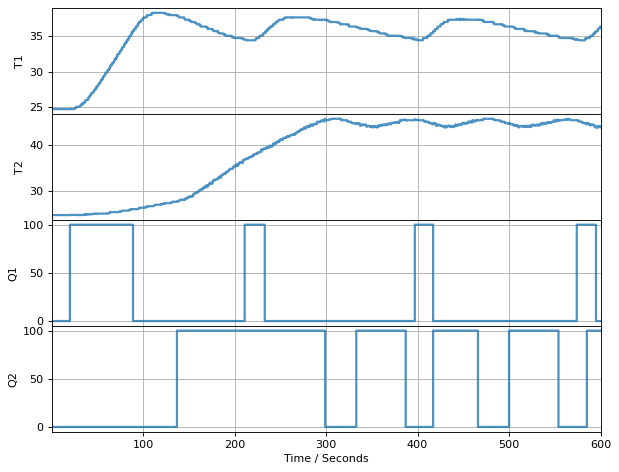

In [12]:
# implement relay control given these set points

%matplotlib inline
from tclab import TCLab, clock, Historian, Plotter

# set constants
d = 0.5 # degrees C
U_min = 0
U_max = 100
t_final = 600 # seconds
t_step = 1 # second

with TCLab() as lab:
    # use current readings to determine T_amb
    T_amb = (lab.T1 + lab.T2)/2
    print('Ambient temperature:',T_amb,'C')
    
    h = Historian(lab.sources)
    p = Plotter(h, t_final)
    U1 = U_min
    U2 = U_min
    
    # implement relay control using set point functions
    for t in clock(t_final, t_step):
        # control T1
        T1 = lab.T1
        if T1 <= sp1(t) - d:
            U1 = U_max
        elif T1 >= sp1(t) + d:
            U1 = U_min
        lab.Q1(U1)
        
        # control T2
        T2 = lab.T2
        if T2 <= sp2(t) - d:
            U2 = U_max
        elif T2 >= sp2(t) + d:
            U2 = U_min
        lab.Q2(U2)
        
        p.update(t)  

### Exercise 1: Second Trial, run for 900 seconds (after cooling)

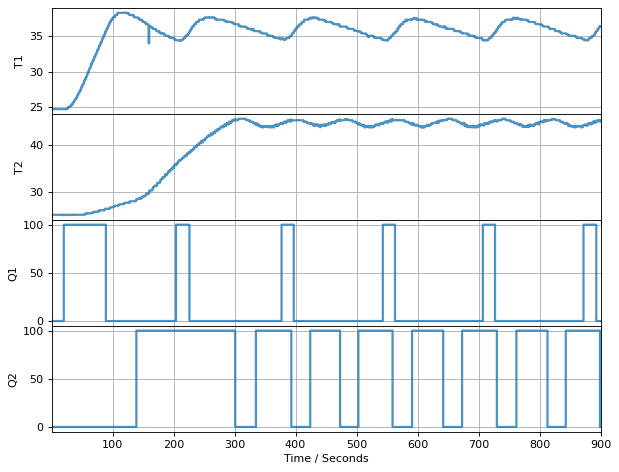

TCLab disconnected successfully.


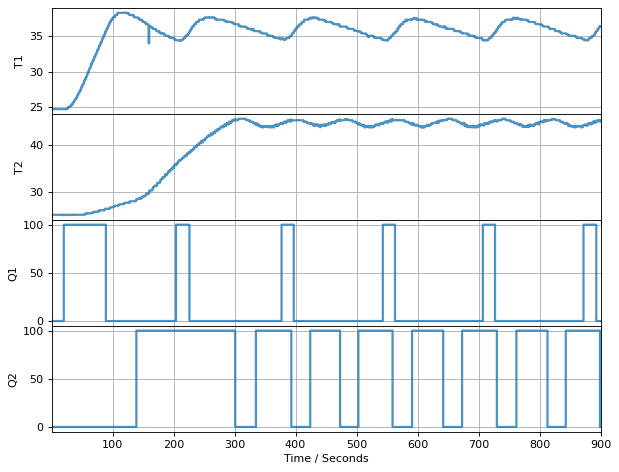

In [13]:
# implement relay control given these set points

%matplotlib inline
from tclab import TCLab, clock, Historian, Plotter

# set constants
d = 0.5 # degrees C
U_min = 0
U_max = 100
t_final = 900 # seconds
t_step = 1 # second

with TCLab() as lab:
    # use current readings to determine T_amb
    T_amb = (lab.T1 + lab.T2)/2
    
    h = Historian(lab.sources)
    p = Plotter(h, t_final)
    U1 = U_min
    U2 = U_min
    
    # implement relay control using set point functions
    for t in clock(t_final, t_step):
        # control T1
        T1 = lab.T1
        if T1 <= sp1(t) - d:
            U1 = U_max
        elif T1 >= sp1(t) + d:
            U1 = U_min
        lab.Q1(U1)
        
        # control T2
        T2 = lab.T2
        if T2 <= sp2(t) - d:
            U2 = U_max
        elif T2 >= sp2(t) + d:
            U2 = U_min
        lab.Q2(U2)
        
        p.update(t)  

1. After the system has settled to a steady oscillation, the maximum deviation from the set point SP1 (for T1) is approximately 2.5 degrees C, and the maximum deviation from the set point SP2 (for T2) is approximately 0.7 degrees C.


2. The manipulated variable Q1 switches to maximum power approximately every 170 seconds (500/3). Its switching behavior is characterized by a quick burst at maximum power and then a long period of zero power to allow the heater to cool. Considering both switching directions, Q1's average switching frequency is approximately once per 80 seconds, or 0.75 (1/minute).
The manipulated variable Q2 switches to maximum power approximately every 80 seconds, making the overall average switching frequency approximately once per 40 seconds, or 1.5 (1/minute).

In [22]:
print(np.max(h.logdict['T2']))

45.713


### Exercise 2

Text(0.5, 1.0, 'Test plot of set point function sp1')

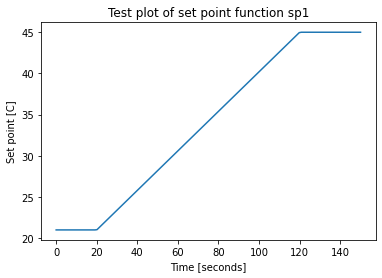

In [30]:
# create function to define set point for H1 and plot to check

# import libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# define function to set SP1
def sp(t):
    if t <= 20:
        return T_amb
    elif t <= 120:
        # set point should be linearly spaced between T_amb and 45
        return T_amb + (45-T_amb)/(120-20)*(t-20)
    else:
        return 45
    
# plot function

# set T_amb as 21 C for this test
T_amb = 21

# create time vector and y1 vector
t = np.linspace(0, 150, 150)
y1 = np.array([sp(tau) for tau in t]) 

# plot SP1
fig, ax = plt.subplots(1, 1)
ax.plot(t, y1)
ax.set_xlabel('Time [seconds]')
ax.set_ylabel('Set point [C]')
ax.set_title('Test plot of set point function sp1')

In [42]:
# implement PI control given these set points

%matplotlib inline
import numpy as np
from tclab import TCLab, clock, Historian, Plotter, setup

           # U1 = lab.Q1()                            # <==== new line
           # U1 = controller.send((sp(t), T1, U1))    # <==== send U1 to controller 

def experiment(controller):

    # time horizon and time step
    t_final = 900
    t_step = 2

    # use existing sp(t) from above

    # perform experiment
    TCLab = setup(connected=False, speedup=100)
    with TCLab() as lab:

        # set up historian and plotter
        h = Historian(lab.sources)
        p = Plotter(h, t_final)

        # initialize manipulated variable
        lab.P1 = 200
        lab.Q1(next(controller))

        # main event loop
        for t in clock(t_final, t_step):
            T1 = lab.T1
            U1 = lab.Q1()                            # <==== new line
            U1 = controller.send((sp(t), T1, U1))    # <==== send U1 to controller 
            lab.Q1(U1)
            p.update(t)   
        
        print('T1 history:')
        print(h.logdict['T1'])

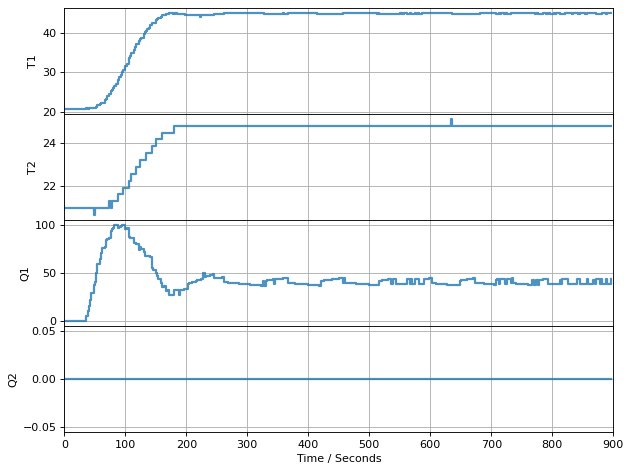

T1 history:
[20.6272, 20.949499999999997, 20.6272, 20.949499999999997, 20.949499999999997, 20.949499999999997, 20.949499999999997, 20.949499999999997, 21.2718, 21.594099999999997, 21.9164, 22.238699999999998, 22.238699999999998, 22.8833, 23.205599999999997, 23.850199999999997, 24.494799999999998, 25.1394, 25.461699999999997, 26.106299999999997, 26.4286, 27.073199999999996, 28.0401, 28.6847, 29.329299999999996, 29.973899999999997, 30.618499999999997, 31.585399999999996, 32.23, 33.5192, 34.163799999999995, 34.8084, 35.775299999999994, 36.4199, 37.064499999999995, 38.0314, 38.353699999999996, 38.675999999999995, 39.6429, 40.287499999999994, 40.6098, 40.9321, 41.2544, 41.898999999999994, 42.5436, 42.5436, 43.188199999999995, 43.51049999999999, 43.8328, 44.1551, 44.477399999999996, 44.477399999999996, 44.799699999999994, 44.799699999999994, 45.122, 45.122, 44.799699999999994, 44.799699999999994, 45.122, 44.799699999999994, 44.799699999999994, 44.799699999999994, 44.799699999999994, 44.79969

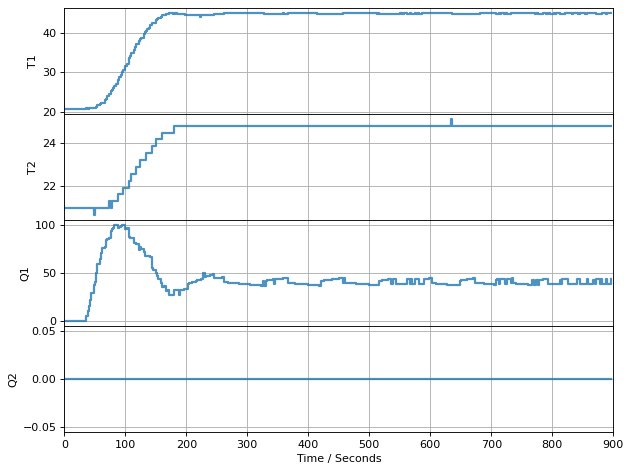

In [46]:
def PI(Kp, Ki, MV_min, MV_max):
    SP, PV, MV = yield MV_min
    MV += -Ki*(PV - SP)
    MV = max(MV_min, min(MV_max, MV))
    PV_prev = PV
    while True:
        SP, PV, MV = yield MV
        MV += -Kp*(PV - PV_prev) - Ki*(PV - SP)
        MV = max(MV_min, min(MV_max, MV))
        PV_prev = PV
        
PI_controller_no_windup = PI(15, 1.2, MV_min=0, MV_max=100)
experiment(PI_controller_no_windup)

After the system has reached a steady oscillation, the maximum deviation from the set point is approximately 0.2 degrees C.